<a href="https://colab.research.google.com/github/emorrow44/DeepFakeDetection/blob/main/GradCamAttempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Implementing Grad-CAM

In [ ]:
!pip install face-recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 24 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=5306b390986ba9721ff6f3ee5b11f3ef5fac63e8a6408b548ec7b7c8e86ae088
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
      for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
          return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
      raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    # record operations for automatic differentiation

    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[: self.classIdx]

    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
    colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

## Creating Visualization Script

In [ ]:
# import the necessary packages
# from pyimagesearch.gradcam import GradCAM
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import sys
import imutils
import cv2

# sys.path.append('/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice')
# from meso4 import *
# from pipelines import *

In [ ]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to the input image")
# ap.add_argument("-m", "--model", type=str, default="vgg",
# 	choices=("vgg", "resnet"),
# 	help="model to be used")
# args = vars(ap.parse_args())

In [ ]:
# initialize the model to be VGG16
model = Meso4()
model.load('/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/Meso4_DF.h5')
model = model.model
#model = model.init_model()
#model.load_weights('/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/Meso4_DF.h5')

# check to see if we are using ResNet
# if args["model"] == "resnet":
# 	Model = ResNet50
# load the pre-trained CNN from disk
print("[INFO] loading model...")
#model = model(weights="imagenet")

[INFO] loading model...


In [ ]:
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
orig = cv2.imread("/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/face.png")
resized = cv2.resize(orig, (256, 256))
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = load_img("/content/gdrive/Shareddrives/FaceForensics++/Grad-CAM practice/face.png", target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = imagenet_utils.preprocess_input(image)

In [ ]:
# use the network to make predictions on the input image and find
# the class label index with the largest corresponding probability
preds = model.predict(image)
i = np.argmax(preds[0])
print(preds, i)
# decode the ImageNet predictions to obtain the human-readable label
# decoded = imagenet_utils.decode_predictions(preds)
# (imagenetID, label, prob) = decoded[0][0]
# label = "{}: {:.2f}%".format(label, prob * 100)
#print("[INFO] {}".format(label))

1/1 [==============================] - 0s 165ms/step
[[1.]] 0


In [ ]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

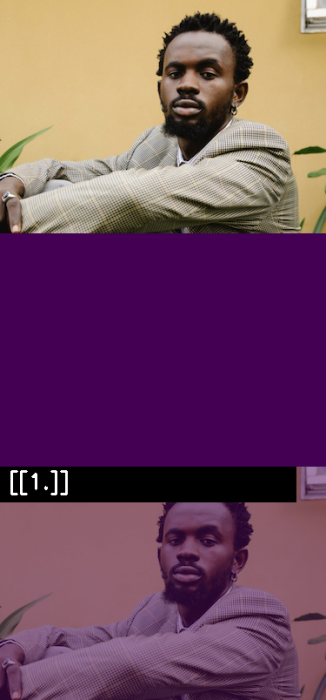

-1

In [ ]:
from google.colab.patches import cv2_imshow

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, str(preds), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)
cv2.waitKey(0)

## Meso-4 Model Check

In [ ]:
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam

IMGWIDTH = 256

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)


class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)